In [11]:
import numpy as np
from Potential import hard_sphere, fourier_charge_distribution, electrostatic
from OZ_class import OrnsteinZernike
import matplotlib.pyplot as plt

# Structure of an ionic microgels suspension through the Ornstein-Zernike equation

The present notebook is aimed to exemplify the application of the Ornstein-Zernike equation to study the radial distributions (https://en.wikipedia.org/wiki/Radial_distribution_function) of an ionic microgels suspension. The system is composed as follows:

- A uniform medium that represents water (blue background)

- Negatively charged microgels denoted by species $M$, with electric charge $q_{M} = -180$ and radius $R_{M} = 51nm$ (green particles)

- Positive small ions (cations) denoted by species $c$, with electric charge $q_{c} = 1$ and radius $R_{c} = 0.6nm$ (red particles)

- Negative small ions (anions) denoted by species $a$, with electric charge $q_{a} = -1$ and radius $R_{a} = 0.6nm$ (blue particles)

<img src="model.png" width="500" height="500" align="center"/>

The main input to work the OZ formalism corresponds to the pair interactions among the species, which essentially gives the force that a particle $\alpha$ exerts on a particle $\mu$ at a distance $r$, where $\alpha$ and  $\mu$ can take the values $M, a, c$. These pair interactions can be comprised by different types of forces, depending on the particular nature of the particles; for our system, we will consider two contributions: one named hard-sphere potential and the second known as electrostatic potential.

In short, the hard-sphere potential is nothing else than the inability of two particles to overlap, like two pool balls colliding. Here, we model the cations and anions to have this characteristic. Yet, since the microgels are porous particles, the cations and anions are capable of entering into the big green particles, so the hard-sphere potential is not considered for the microgel-anion and microgel-cation pairs.

On the other hand, the electrostatic potential is something similar to the Coulomb force that is often taught in high school. The important part to remember here is that particles with the same electric charge sign repel each other, while particles with different signs attract. Also, this repulsion/attraction is stronger if the distance between the particles is small, and weakens if they are more separated, even vanishing when both particles are very far away.

Other inputs of the OZ equation are the density (or concentration) of each species, and a more abstract feature given by an approximation to work with (known as closure), but this last is beyond the scope of the notebook.

For a complete description of the system, the reader is referenced to:
https://aip.scitation.org/doi/10.1063/1.4941324
https://pubs.rsc.org/en/content/articlelanding/2020/sm/d0sm00486c

### Scripts

In order to have a cleaner and more interpretably code, the functions defining the potentials commented previously are coded in the Potential.py script, while the functions of the Ornstein Zernike formalism and the way to solve it are defined in the OrnsteinZernike class in the OZ_class.py script. The only thing left to define are the parameters to use in the potentials:

In [12]:
#The parameters of the potential are defined in this cell

#Charge of the species (in proton charge units):
qm = -180
qc = 1
qa = -1
qv = np.array([[qm],[qc],[qa]])


#Densities (in nanometers^{-3})
rho_m = 1.3*(10**-9)
rho_a = 0.60221413*10**-7
rho_c = -(qm*rho_m + qa*rho_a)/qc   #rho_c is determined by the electroneutrality condition
Rd = np.array([[rho_m,0,0],[0,rho_c,0],[0,0,rho_a]])


#Hard-sphere diameters (in nanometers)
sigma = np.array([[0,0,0],[0,0.6,0.6],[0,0.6,0.6]])

#External radius (in nanometers):
Rm = 51
Rc = sigma[1,1]/2
Ra = sigma[2,2]/2
Rv = np.array([[Rm],[Rc],[Ra]])

#Internal radius
Sm = 0.9*Rm #macroion
Sc = 0
Sa = 0
Sv = np.array([[Sm],[Sc],[Sa]])

#Bjerrum length (in nanometers)
lb = 0.71432

In [13]:
#The OrnsteinZernike class has already a good discretization of the real and Fourier space for this problem
r = OrnsteinZernike.__dict__['r']
k = OrnsteinZernike.__dict__['k']
N = OrnsteinZernike.__dict__['N']
M = len(Rd)

### Applying the OrnsteinZernike class

The OrnsteinZernike class solves de OZ equation using the Newton's method combined with a Krylov-space linear solver (gradient descent and conjugate gradient descent are examples of these solvers).

In [14]:
#Newton's method requires an initial guess for the numerical solution. 
#If it does not converge, a possible way around is with numerical continuation: 
#https://en.wikipedia.org/wiki/Numerical_continuation

#Initial guess of the short-range indirect correlation function.
gs_initial = np.zeros([N,M,M])

short_range_interactions_r = hard_sphere(r, sigma)

zk = fourier_charge_distribution(k, qv, Rv, Sv)

long_range_interactions_k = electrostatic(k, zk, lb = lb)

In [15]:
OZ = OrnsteinZernike(Rd, short_range_interactions_r, long_range_interactions_k, gs_initial)
OZ.solve()

#Obtaining the radial distribution function once the equation has been solved
gr = OZ.radial_distribution()

newton_method_step = 0 current_error = 11.251400679443838
newton_method_step = 1 current_error = 7.410671072659331
newton_method_step = 2 current_error = 3.973135468563891
newton_method_step = 3 current_error = 4.636431824808916
newton_method_step = 4 current_error = 4.6640083583699266
newton_method_step = 5 current_error = 2.723293207658301
newton_method_step = 6 current_error = 0.5662108637979734
newton_method_step = 7 current_error = 0.016997901004234258
newton_method_step = 8 current_error = 1.7325881632537785e-05
newton_method_step = 9 current_error = 1.9051611584120408e-08
Solved


### Radial Distribution Functions

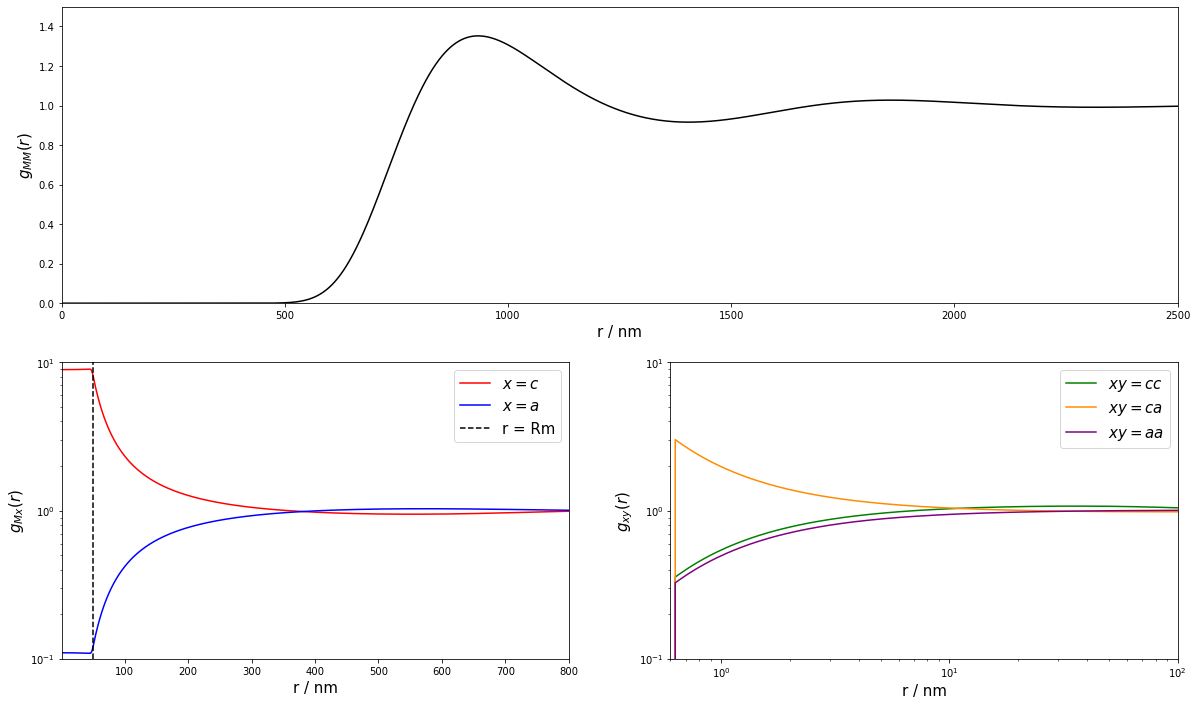

In [16]:
f = gr

plt.figure(figsize = (20,12))

ax1 = plt.subplot(211)
ax1.plot(r, f[:,0,0], color = 'black')
ax1.set_xlabel('r / nm', fontsize = 15)
ax1.set_ylabel('$g_{MM}(r)$', fontsize = 15)
ax1.set_xlim(0, 2500)
ax1.set_ylim(0,1.5)

ax2 = plt.subplot(223)
ax2.plot(r, f[:,0,1], label = r'$x = c$', color = 'red')
ax2.plot(r, f[:,0,2], label = r'$x = a$', color = 'blue')
ax2.set_xlabel('r / nm', fontsize = 15)
ax2.set_ylabel(r'$g_{M x}(r)$', fontsize = 15)
ax2.semilogy()
ax2.set_xlim(1, 800)
ax2.set_ylim(10**-1, 10)
ax2.axvline(x=Rm, color = 'black', linestyle = '--', label = 'r = Rm')
ax2.legend(fontsize = 15)


ax3 = plt.subplot(224)
ax3.plot(r, f[:,1,1], label = r'$xy = cc$', color = 'green')
ax3.plot(r, f[:,1,2], label = r'$xy = ca$', color = 'darkorange')
ax3.plot(r, f[:,2,2], label = r'$xy = aa$', color = 'purple')
ax3.set_xlabel('r / nm', fontsize = 15)
ax3.set_ylabel(r'$g_{x y}(r)$', fontsize = 15)
ax3.loglog()
ax3.set_xlim(0.6, 100)
ax3.set_ylim(10**-1, 10)
ax3.legend(fontsize = 15)

#### Visual representation of the resulting radial distributions
<img src="grvisual.png" width="600" height="400" align="center"/>


- The $g_{MM}(r)$ function (top panel) shows that the average distance between a microgel and its first microgel neighbor is around $900$ nm, and actually it is highly unlikely that these particles come closer than $500$ nm each other. For simplicity, the visual representation only shows two microgels, but there are many more.


- The constant behavior of $g_{Mc}(r)$ (bottom left panel) before $r = R_{M}$ (dashed line) and the subsequent decay illustrates that cations tend to be ingested by the microgels, whereas anions are expelled as seen by the inverse behavior of $g_{Ma}(r)$ (same signs repel, different signs attract).


- The $g_{ca}(r)$ function (bottom right panel) shows the mild attraction between anions and cations, mostly happening outside the microgels. The abrupt part at the beginning of the plot illustrates the effects of the hard-sphere potential.



- Lastly, the functions $g_{cc}(r)$ and $g_{aa}(r)$ (bottom right panel) show a similar shape: both start from values less than 1 and go monotonically to this limit, which is a characteristic behavior of dilute species with weak interactions. The case corresponding to the cation-cation distribution reachs slightly higher values, which is generated by the more concentrated cations inside the microgels.